In [270]:
import pandas as pd
import sqlite3
import numpy as np
from datetime import datetime
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostClassifier

In [271]:
connEmpleados = sqlite3.connect('data/empleados.db')
connVacaciones = sqlite3.connect('data/vacaciones.db')
connDepartamentos = sqlite3.connect('data/departamentos.db')

In [272]:
dfEmpleados = pd.read_sql_query('SELECT * FROM empleados', connEmpleados)
dfVacaciones = pd.read_sql_query('SELECT * FROM vacaciones', connVacaciones)
dfDepartamentos = pd.read_sql_query('SELECT * FROM departamentos', connDepartamentos)

In [273]:
# Cerrar las conexiones a las bases de datos
connEmpleados.close()
connVacaciones.close()
connDepartamentos.close()

In [274]:
dfEmpleados['minusvalia'] = dfEmpleados['minusvalia'].map({'Sí': True, 'No': False}).fillna(False)
dfEmpleados['activo'] = dfEmpleados['activo'].map({1: True, 0: False}).fillna(False)

/tmp/ipykernel_26755/1804539808.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dfEmpleados['activo'] = dfEmpleados['activo'].map({1: True, 0: False}).fillna(False)


In [275]:
date_columns_vacaciones = ['vacaciones_inicio', 'vacaciones_fin', 'fecha_solicitud']
for col in date_columns_vacaciones:
    dfVacaciones[col] = pd.to_datetime(dfVacaciones[col])

dfVacaciones['duracion_solicitud_dias'] = (dfVacaciones['vacaciones_fin'] - dfVacaciones['vacaciones_inicio']).dt.days + 1

In [276]:
df_merged = pd.merge(dfVacaciones, dfEmpleados, left_on='id_empleado', right_on='id_empleado', how='left')

df_final = pd.merge(df_merged, dfDepartamentos, left_on='id_departamento', right_on='id_departamento', how='left', suffixes=('_empleado', '_departamento'))

In [277]:
columnas_relevantes = [
    'id_departamento',
    'fecha_solicitud',
    'vacaciones_inicio',
    'vacaciones_fin',
    'duracion_solicitud_dias',
    'estado_solicitud',
    'antiguedad_anos',
    'personas_a_cargo',
    'rol_empleado',
    'activo',
    'id_departamento',
    'nombre_departamento',
    'porcentaje_maximo_inactivos',
    'numero_total_empleados'
    # Aquí faltan las columnas 'es_rol_critico', 'tuvo_vacaciones_deseadas_ano_pasado',
    # 'dias_acumulados_vacaciones', 'dias_disfrutados_vacaciones_ano_actual'
    # que mencionamos como datos adicionales importantes.
]

In [278]:
df_modelo = df_final[columnas_relevantes].copy()

In [279]:
df_modelo['es_rol_critico'] = df_modelo['rol_empleado'].apply(lambda rol: True if rol in ['Director de tienda', 'Gerente de tienda'] else False)

In [280]:
df_modelo['dias_acumulados_vacaciones'] = np.random.randint(1, 31, size=len(df_modelo))
df_modelo['dias_disfrutados_vacaciones_ano_actual'] = np.random.randint(0, df_modelo['dias_acumulados_vacaciones'], size=len(df_modelo))
df_modelo['tiene_personas_a_cargo'] = df_modelo['personas_a_cargo'].apply(lambda x: True if x > 0 else False)

In [281]:
def calcular_prioridad(row):
    score = 0

    # Antigüedad
    score += row['antiguedad_anos'] * 2

    # Situación familiar
    if row['tiene_personas_a_cargo']:
        score += 3

    # Días acumulados vs disfrutados
    if row['dias_disfrutados_vacaciones_ano_actual'] == 0:
        score += 4  # No ha tenido vacaciones este año
    score += (row['dias_acumulados_vacaciones'] - row['dias_disfrutados_vacaciones_ano_actual']) * 0.5

    # Rol crítico (penalización)
    if row['es_rol_critico']:
        score -= 3

    # Fecha de solicitud (más temprano = más puntos)
    # Convertir la fecha de solicitud a datetime si no lo es
    if not isinstance(row['fecha_solicitud'], datetime):
        try:
            fecha_solicitud = pd.to_datetime(row['fecha_solicitud'])
        except ValueError:
            return None, "Error: Fecha de solicitud inválida"
    else:
        fecha_solicitud = row['fecha_solicitud']

    dias_desde_solicitud = (datetime.now() - fecha_solicitud).days
    score += dias_desde_solicitud * 0.1

    return score

df_modelo['prioridad'] = df_modelo.apply(calcular_prioridad, axis=1)

In [282]:
df_modelo.sample(10)

,id_departamento,fecha_solicitud,vacaciones_inicio,vacaciones_fin,duracion_solicitud_dias,estado_solicitud,antiguedad_anos,personas_a_cargo,rol_empleado,activo,id_departamento,nombre_departamento,porcentaje_maximo_inactivos,numero_total_empleados,es_rol_critico,dias_acumulados_vacaciones,dias_disfrutados_vacaciones_ano_actual,tiene_personas_a_cargo,prioridad
22979,7,2024-04-26,2024-08-16,2024-08-25,10,aprobada,16,3,Director de tienda,False,7,Logística,28,24,True,19,0,True,81.7
77551,6,2024-04-28,2024-08-28,2024-09-09,13,aprobada,3,3,Gerente de tienda,False,6,Finanzas,30,24,True,22,0,True,57.0
82563,7,2025-02-08,2025-03-02,2025-03-04,3,rechazada,12,5,Jefe de tienda,False,7,Logística,28,24,False,22,16,True,37.4
1355,3,2024-11-29,2025-01-04,2025-01-30,27,aprobada,11,4,Encargado de tienda,False,3,Marketing,21,27,False,28,2,True,52.5
46349,4,2024-09-29,2025-03-26,2025-04-22,28,aprobada,5,0,Jefe de sección,False,4,Desarrollo de Producto,12,18,False,6,5,False,31.1
26862,5,2025-01-03,2025-01-30,2025-02-16,18,aprobada,3,0,Subdirector de tienda,False,5,Atención al Cliente,28,16,False,23,7,False,25.0
14204,7,2024-12-01,2025-01-20,2025-01-27,8,rechazada,21,3,Gerente de tienda,False,7,Logística,28,24,True,10,5,True,58.8
49577,3,2024-07-29,2024-08-17,2024-08-22,6,rechazada,6,5,Gerente de tienda,False,3,Marketing,21,27,True,1,0,True,43.3
69802,5,2024-11-02,2024-11-21,2024-12-03,13,aprobada,0,7,Encargado de tienda,False,5,Atención al Cliente,28,16,False,8,0,True,28.2
8642,7,2024-09-06,2025-02-04,2025-02-19,16,rechazada,35,6,Encargado de tienda,False,7,Logística,28,24,False,1,0,True,100.4


In [283]:
df_modelo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 19 columns):
 #   Column                                  Non-Null Count   Dtype         
---  ------                                  --------------   -----         
 0   id_departamento                         100000 non-null  int64         
 1   fecha_solicitud                         100000 non-null  datetime64[ns]
 2   vacaciones_inicio                       100000 non-null  datetime64[ns]
 3   vacaciones_fin                          100000 non-null  datetime64[ns]
 4   duracion_solicitud_dias                 100000 non-null  int64         
 5   estado_solicitud                        100000 non-null  object        
 6   antiguedad_anos                         100000 non-null  int64         
 7   personas_a_cargo                        100000 non-null  int64         
 8   rol_empleado                            100000 non-null  object        
 9   activo                                

In [284]:
df_modelo['estado_solicitud'].value_counts()

estado_solicitud
aprobada     50195
rechazada    49805
Name: count, dtype: int64

In [285]:
# 1. Convertir columnas de fecha a numérica (días desde una fecha de referencia)
fecha_referencia = pd.to_datetime('2024-01-01')
df_modelo['fecha_solicitud_num'] = (pd.to_datetime(df_modelo['fecha_solicitud']) - fecha_referencia).dt.days
df_modelo['vacaciones_inicio_num'] = (pd.to_datetime(df_modelo['vacaciones_inicio']) - fecha_referencia).dt.days
df_modelo['vacaciones_fin_num'] = (pd.to_datetime(df_modelo['vacaciones_fin']) - fecha_referencia).dt.days

In [286]:
# 2. Codificar 'estado_solicitud'
df_modelo['estado_solicitud_num'] = df_modelo['estado_solicitud'].map({'aprobada': 1, 'rechazada': 0})

In [287]:
# 3. Codificar 'rol_empleado' y 'nombre_departamento' usando Label Encoding
label_encoder_rol = LabelEncoder()
df_modelo['rol_empleado_num'] = label_encoder_rol.fit_transform(df_modelo['rol_empleado'])

label_encoder_departamento = LabelEncoder()
df_modelo['nombre_departamento_num'] = label_encoder_departamento.fit_transform(df_modelo['nombre_departamento'])

In [288]:
# 4. Convertir 'activo', 'tiene_personas_a_cargo' y 'es_rol_critico' a numérico (0 o 1)
df_modelo['activo_num'] = df_modelo['activo'].astype(int)
df_modelo['tiene_personas_a_cargo_num'] = df_modelo['tiene_personas_a_cargo'].astype(int)
df_modelo['es_rol_critico_num'] = df_modelo['es_rol_critico'].astype(int)

In [289]:
df_modelo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 28 columns):
 #   Column                                  Non-Null Count   Dtype         
---  ------                                  --------------   -----         
 0   id_departamento                         100000 non-null  int64         
 1   fecha_solicitud                         100000 non-null  datetime64[ns]
 2   vacaciones_inicio                       100000 non-null  datetime64[ns]
 3   vacaciones_fin                          100000 non-null  datetime64[ns]
 4   duracion_solicitud_dias                 100000 non-null  int64         
 5   estado_solicitud                        100000 non-null  object        
 6   antiguedad_anos                         100000 non-null  int64         
 7   personas_a_cargo                        100000 non-null  int64         
 8   rol_empleado                            100000 non-null  object        
 9   activo                                

In [290]:
# 1. Definir las características (X) y la variable objetivo (y)
columnas_para_entrenamiento = [
    'duracion_solicitud_dias',
    'antiguedad_anos',
    'personas_a_cargo',
    'activo_num',
    'porcentaje_maximo_inactivos',
    'numero_total_empleados',
    'es_rol_critico_num',
    'dias_acumulados_vacaciones',
    'dias_disfrutados_vacaciones_ano_actual',
    'tiene_personas_a_cargo_num',
    'prioridad',
    'fecha_solicitud_num',
    'vacaciones_inicio_num',
    'vacaciones_fin_num',
    'rol_empleado_num',
    'nombre_departamento_num'
]
X = df_modelo[columnas_para_entrenamiento]
y = df_modelo['estado_solicitud_num']

In [291]:
# 2. Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [292]:
# 3. Inicializar y entrenar los modelos
# Modelo 1: Regresión Logística
logreg_model = LogisticRegression(random_state=42, solver='liblinear')
logreg_model.fit(X_train, y_train)

# Modelo 2: Bosque Aleatorio
rf_model = RandomForestClassifier(random_state=42, n_estimators=100)
rf_model.fit(X_train, y_train)

# Modelo 3: XGBoost
xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)

/home/alee/.local/share/virtualenvs/chronosAI-bGPFpNdy/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [20:36:12] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [293]:
# 4. Hacer predicciones en el conjunto de prueba
logreg_predictions = logreg_model.predict(X_test)
rf_predictions = rf_model.predict(X_test)
xgb_predictions = xgb_model.predict(X_test)

--- Resultados de Regresión Logística ---
Accuracy: 0.5028666666666667
Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.51      0.50     14800
           1       0.51      0.50      0.50     15200

    accuracy                           0.50     30000
   macro avg       0.50      0.50      0.50     30000
weighted avg       0.50      0.50      0.50     30000



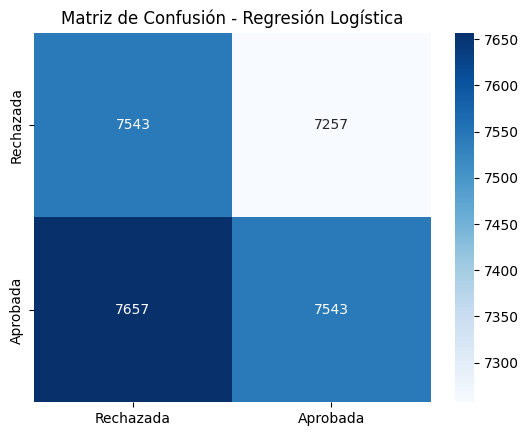


--- Resultados de Bosque Aleatorio ---
Accuracy: 0.5001666666666666
Classification Report:
               precision    recall  f1-score   support

           0       0.49      0.53      0.51     14800
           1       0.51      0.48      0.49     15200

    accuracy                           0.50     30000
   macro avg       0.50      0.50      0.50     30000
weighted avg       0.50      0.50      0.50     30000



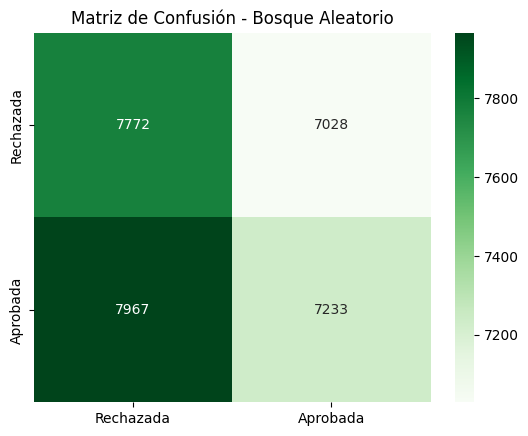


--- Resultados de XGBoost ---
Accuracy: 0.5015
Classification Report:
               precision    recall  f1-score   support

           0       0.49      0.50      0.50     14800
           1       0.51      0.50      0.50     15200

    accuracy                           0.50     30000
   macro avg       0.50      0.50      0.50     30000
weighted avg       0.50      0.50      0.50     30000



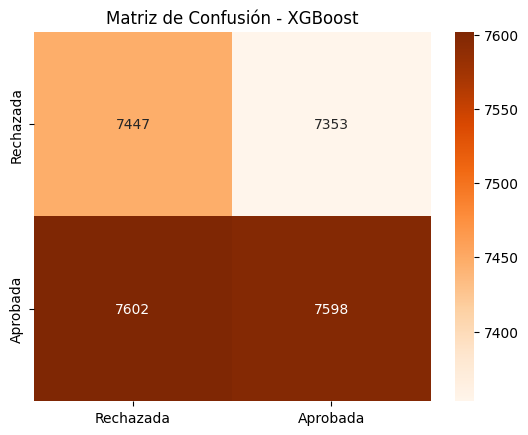

In [294]:
# 5. Evaluar los modelos
print("--- Resultados de Regresión Logística ---")
print("Accuracy:", accuracy_score(y_test, logreg_predictions))
print("Classification Report:\n", classification_report(y_test, logreg_predictions))
conf_matrix_logreg = confusion_matrix(y_test, logreg_predictions)
sns.heatmap(conf_matrix_logreg, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Rechazada', 'Aprobada'], yticklabels=['Rechazada', 'Aprobada'])
plt.title('Matriz de Confusión - Regresión Logística')
plt.show()

print("\n--- Resultados de Bosque Aleatorio ---")
print("Accuracy:", accuracy_score(y_test, rf_predictions))
print("Classification Report:\n", classification_report(y_test, rf_predictions))
conf_matrix_rf = confusion_matrix(y_test, rf_predictions)
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Rechazada', 'Aprobada'], yticklabels=['Rechazada', 'Aprobada'])
plt.title('Matriz de Confusión - Bosque Aleatorio')
plt.show()

print("\n--- Resultados de XGBoost ---")
print("Accuracy:", accuracy_score(y_test, xgb_predictions))
print("Classification Report:\n", classification_report(y_test, xgb_predictions))
conf_matrix_xgb = confusion_matrix(y_test, xgb_predictions)
sns.heatmap(conf_matrix_xgb, annot=True, fmt='d', cmap='Oranges',
            xticklabels=['Rechazada', 'Aprobada'], yticklabels=['Rechazada', 'Aprobada'])
plt.title('Matriz de Confusión - XGBoost')
plt.show()